# Whitelists
In this tutorial we make use of whitelists and minimum collisional radius in order to control the events we are interested in tracking, and thus increase the overall simulation speed.

```{note}
Having to track less collisional and conjunction events has a great impact on the so-called narrow-phase of the cascade algorithm, that is the phase where cascade checks if some of the propagated objects' orbits trigger events. All other algoritmic phases are not affected by whitelists.
```

Let us start with some imports:

In [1]:
# core imports
import cascade as csc
import pykep as pk
import numpy as np
import heyoka as hy

# plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline

## The dynamics

For this tutorial we will make use the same non dimensional Keplerian dynamics used in [quickstart](<./quickstart.ipynb>): a purely keplerian dynamics.

Let us instantiate it:

In [2]:
dyn = csc.dynamics.kepler(mu = 1)


```{note}
The units we are going to use are $L=670000 [m]$ for ength and $MU=3.98600E14 [m^3/s^2]$ for the gravity parameter. The orbits can thus be considered as orbiting the Earth.
```

## The initial conditions

We consider two separated types of orbiting objects. A debris cloud made of 10000 small debris pieces of radius 5cm=7.46e-7L and 2 active satellites operating in the same orbital environment. We will randomly create both the debris cloud and the satellite orbits.
```{tip}
To create the random orbits we can use the very same procedure we have used in the notebooks [quickstart](<./quickstart.ipynb>) and [conjunctions](<./conjunctions.ipynb>)
```

In [3]:
N = 10000 # size of the debris cloud
M = 2     # number of active satellites

# The following numpy array will hold all the initial conditions and object radius [x,y,z,vx,vy,vz,r]
ic_state = np.zeros((N + M, 7))

# We generate randomly orbital parameters and dimensions and transform them to Cartesian state. 
# Note we make use of nondimensional units as defined in the dynamics.
for i in range(N):
    a = np.random.uniform(1.1, 1.2)
    e = np.random.uniform(0.001, 0.02)
    inc = np.random.uniform(np.pi/2-0.01, np.pi/2+0.01)
    om = np.random.uniform(0, 2 * np.pi)
    Om = np.random.uniform(np.pi/3, np.pi/3 + 0.05)
    nu = np.random.uniform(0, 2 * np.pi)
    r, v = pk.par2ic([a, e, inc, Om, om, nu], mu = 1.)
    ic_state[i][:3] = r
    ic_state[i][3:6] = v
    ic_state[i][6] = 7.46e-7

for i in range(i+1, i+M+1):
    a = np.random.uniform(1.1, 1.2)
    e = np.random.uniform(0, 0.02)
    inc = np.random.uniform(np.pi/2-0.01, np.pi/2 + 0.01)
    om = np.random.uniform(0, 2*np.pi)
    Om = np.random.uniform(np.pi/3, np.pi/3 + 0.05)
    nu = np.random.uniform(0, 2*np.pi)
    r, v = pk.par2ic([a, e, inc, Om, om, nu], mu = 1.)
    ic_state[i][:3] = r
    ic_state[i][3:6] = v
    ic_state[i][6] = 2.985E-7

... and we visualize them in proportion to the Earth

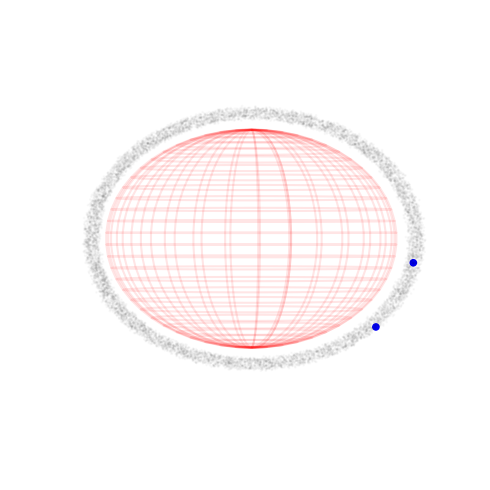

In [4]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

r = 1
u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:30j]
x = r*np.cos(u)*np.sin(v)
y = r*np.sin(u)*np.sin(v)
z = r*np.cos(v)
ax.plot_wireframe(x, y, z, color="r", alpha=0.1)

# Plot the debris cloud
ax.scatter3D(ic_state[:,0], ic_state[:,1], ic_state[:,2], alpha=0.02, s= 1, c='k')

# Plot the active satellites
ax.scatter3D(ic_state[-2:,0], ic_state[-2:,1], ic_state[-2:,2], alpha=1, s= 20, c='b')


ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

ax.view_init(0,-15)

plt.axis('off')
plt.tight_layout()

## Building the simulation

We now want to setup a simulation that tracks collisions and conjunctions and assess its computational complexity. Since we have 10002 orbiting objects, the collisional dynamics may be demanding. 

Before starting a simulation we thus perform some profiling to assess the complexity.

```{tip}
When setting up a new simulation and before running it, profiling the single steps as done here, as to be aware of the various timings involved can help to set the simulation parameters!
```

We start by instantiating the simulation object (see {class}`cascade.sim`).

In [5]:
sim = csc.sim(state = ic_state, dyn=dyn, ct = 2*np.pi / 10, conj_thresh = 1.5e-4, n_par_ct = 10)

We now manually perform a few steps we will discard as unreliable to then set the logger at a `trace` level to investigate the performances on the following step.

In [6]:
skip = 5

In [7]:
csc.set_logger_level_info()
for i in range(skip):
    sim.step()
csc.set_logger_level_trace()
sim.step()

[2023-02-20 15:18:49.487] [cascade] [trace] ---- STEP BEGIN ---
[2023-02-20 15:18:49.487] [cascade] [trace] Number of chunks: 10
[2023-02-20 15:18:49.493] [cascade] [trace] Propagation + AABB computation time: 0.005623239s
[2023-02-20 15:18:49.494] [cascade] [trace] Morton encoding and sorting time: 0.000868703s
[2023-02-20 15:18:49.498] [cascade] [trace] BVH construction time: 0.003746423s
[2023-02-20 15:18:49.514] [cascade] [trace] Broad phase collision detection time: 0.016538086s
[2023-02-20 15:18:49.514] [cascade] [trace] Average number of AABB collisions per particle per chunk: 64.53106378724254
[2023-02-20 15:18:49.768] [cascade] [trace] Narrow phase collision detection time: 0.253979335s
[2023-02-20 15:18:49.768] [cascade] [trace] Total number of collisions detected: 0
[2023-02-20 15:18:49.768] [cascade] [trace] Total number of conjunctions detected: 12
[2023-02-20 15:18:49.768] [cascade] [trace] Runtime for append_conj_data(): 4.2e-06s
[2023-02-20 15:18:49.768] [cascade] [trac

<outcome.success: 0>

The numerical propagation, i.e. the call to all the Taylor integrators needed to construct a piecewise continuous representation of the trajectory of each object in the step (of size ``n_par_ct`` times ``ct``) as well as other parts of the cascade algorithm seem to not have much of an impact in this particular simulation. The main contribution to the total propagation time derives from the narrow phase collision. And this is where whitelists and minimal collision radius play a great role!

```{tip}
Whenever you are only interested in some specific orbiting objects, or want to exclude the detection of collisions between small objects use whitelists and set a minimal collision radius to shorten the narrow phase collision timings.
```

Since its only the active satellites that are of interest to us we will inform the cascade simulation to only care about those, ignore all the others. We also set here a ``min_coll_radius`` to exclude the detection of collisions between small debris. This is actually not needed here as the whitelists already exclude them, but we wanted to show that part of the API here too for completeness.

In [8]:
sim2 = csc.sim(state = ic_state, dyn=dyn, ct = 2*np.pi / 10, conj_thresh = 1.5e-4, n_par_ct = 10, conj_whitelist=set([10000, 10001]), coll_whitelist=set([10000, 10001]), min_coll_radius=1e-8)

[2023-02-20 15:18:50.190] [cascade] [trace] Integrators setup time: 0.346186353s
[2023-02-20 15:18:50.346] [cascade] [trace] JIT functions setup time: 0.155735316s


In [9]:
csc.set_logger_level_info()
for i in range(skip):
    sim2.step()
csc.set_logger_level_trace()
sim2.step()

[2023-02-20 15:18:50.948] [cascade] [trace] ---- STEP BEGIN ---
[2023-02-20 15:18:50.948] [cascade] [trace] Number of chunks: 10
[2023-02-20 15:18:50.954] [cascade] [trace] Propagation + AABB computation time: 0.006051181s
[2023-02-20 15:18:50.956] [cascade] [trace] Morton encoding and sorting time: 0.001223794s
[2023-02-20 15:18:50.960] [cascade] [trace] BVH construction time: 0.004123854s
[2023-02-20 15:18:50.975] [cascade] [trace] Broad phase collision detection time: 0.014795491s
[2023-02-20 15:18:50.975] [cascade] [trace] Average number of AABB collisions per particle per chunk: 0.01936612677464507
[2023-02-20 15:18:50.975] [cascade] [trace] Narrow phase collision detection time: 0.000364852s
[2023-02-20 15:18:50.975] [cascade] [trace] Total number of collisions detected: 0
[2023-02-20 15:18:50.975] [cascade] [trace] Total number of conjunctions detected: 0
[2023-02-20 15:18:50.975] [cascade] [trace] Runtime for append_conj_data(): 1.47e-06s
[2023-02-20 15:18:50.975] [cascade] [tr

<outcome.success: 0>

The **narrow phase collision detection time** cost has decreased dramatically since cascade needs now to only care about collisions and conjunctions events of two objects and not 10002! The overall time saving is of one order magnitude!